## Z Token Lockdrop Distribution

In [1]:
from decimal import Decimal, ROUND_DOWN, getcontext
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import urbitob
import json
from collections import defaultdict

# Set matplotlib style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Configure matplotlib for high-quality plots
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

# Fix font warnings by using DejaVu Sans which supports Unicode subscripts
# or fall back to a safe font
try:
    plt.rcParams['font.family'] = 'DejaVu Sans'
except:
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Liberation Sans', 'Arial', 'Helvetica']

# Disable Unicode minus to avoid font issues
plt.rcParams['axes.unicode_minus'] = False

getcontext().prec = 28
getcontext().rounding = ROUND_DOWN

### Constants

In [2]:
# Constants

TOKEN_PRECISION = Decimal('0.00000001') # 8 decimal precision

# 1 $Z per Urbit ID
total_supply = 4294967296

# 30%
lockdrop_allocation_percent = Decimal('0.3')
lockdrop_allocation = total_supply * lockdrop_allocation_percent

# points
num_galaxies = pow(2, 8)
num_stars = pow(2, 16) - pow(2, 8)
num_planets = pow(2, 32) - pow(2, 16)

# allocation distribution between galaxies and stars (equal distribution amongst these 2^16 points)
star_allocation_percent = Decimal(num_stars / pow(2, 16))
galaxy_allocation_percent = 1 - star_allocation_percent

# lockdrop duration
# 5 years, including 1 leap year
lockdrop_duration_seconds = 5 * 365.25 * 24 * 60 *60

# approximation
block_duration_seconds = 2
lockdrop_duration_blocks = int(lockdrop_duration_seconds / block_duration_seconds)

####################################################

# Display constants as tables
print("=" * 80)
print("📊 $Z LOCKDROP DISTRIBUTION - CORE CONSTANTS")
print("=" * 80)

# Lockdrop Allocation Table
lockdrop_df = pd.DataFrame({
    'Parameter': ['Total Supply (1 $Z per Urbit ID)', 'Lockdrop Allocation %', 'Lockdrop Allocation ($Z)'],
    'Value': [f"{total_supply:,}", f"{lockdrop_allocation_percent:.1%}", f"{lockdrop_allocation:,.1f}"]
})
print("\n🔒 LOCKDROP ALLOCATION")
print(lockdrop_df.to_string(index=False))

# Points Distribution Table
points_df = pd.DataFrame({
    'Point Type': ['Galaxies', 'Stars', 'Planets'],
    'Count': [f"{num_galaxies:,}", f"{num_stars:,}", f"{num_planets:,}"],
    'Allocation %': ['0.39%', '99.61%', '0%']
})
print("\n⭐ URBIT POINTS DISTRIBUTION")
print(points_df.to_string(index=False))

# Lockdrop Parameters Table
params_df = pd.DataFrame({
    'Parameter': ['Block Duration', 'Max Point Lock Duration (5 yrs)', 'Total Blocks', 'Star Allocation %', 'Galaxy Allocation %'],
    'Value': [f"{block_duration_seconds} seconds", f"{lockdrop_duration_seconds:,.0f} seconds",
             f"{lockdrop_duration_blocks:,}", f"{star_allocation_percent:.6f}", f"{galaxy_allocation_percent:.6f}"]
})
print("\n⏱️ LOCKDROP PARAMETERS")
print(params_df.to_string(index=False))
print("\n" + "="*80)

📊 $Z LOCKDROP DISTRIBUTION - CORE CONSTANTS

🔒 LOCKDROP ALLOCATION
                       Parameter           Value
Total Supply (1 $Z per Urbit ID)   4,294,967,296
           Lockdrop Allocation %           30.0%
        Lockdrop Allocation ($Z) 1,288,490,188.8

⭐ URBIT POINTS DISTRIBUTION
Point Type         Count Allocation %
  Galaxies           256        0.39%
     Stars        65,280       99.61%
   Planets 4,294,901,760           0%

⏱️ LOCKDROP PARAMETERS
                      Parameter               Value
                 Block Duration           2 seconds
Max Point Lock Duration (5 yrs) 157,788,000 seconds
                   Total Blocks          78,894,000
              Star Allocation %            0.996093
            Galaxy Allocation %            0.003906



### Calculations

In [3]:
# Calculations

lockdrop_allocation_stars = lockdrop_allocation * star_allocation_percent
lockdrop_allocation_galaxies = lockdrop_allocation * galaxy_allocation_percent

assert (lockdrop_allocation_stars + lockdrop_allocation_galaxies) == lockdrop_allocation, "point allocation doesn't add up"

# Max allocation a star can get
max_allocation_per_star = lockdrop_allocation_stars / num_stars
max_allocation_per_galaxy = lockdrop_allocation_galaxies / num_galaxies

# Quanta calculation
z_available_per_star_per_block = max_allocation_per_star / lockdrop_duration_blocks
z_available_per_galaxy_per_block = max_allocation_per_galaxy / lockdrop_duration_blocks

# Round down z_available_per_star_per_block to 6 decimals
adjusted_z_per_star_per_block = z_available_per_star_per_block.quantize(Decimal('0.000001'), rounding=ROUND_DOWN)
adjusted_z_per_galaxy_per_block = z_available_per_galaxy_per_block.quantize(Decimal('0.000001'), rounding=ROUND_DOWN)

# Adjusted max allocation a star can get
adjusted_max_allocation_per_star = adjusted_z_per_star_per_block * lockdrop_duration_blocks
adjusted_max_allocation_per_galaxy = adjusted_z_per_galaxy_per_block * lockdrop_duration_blocks

rounding_error_per_star = max_allocation_per_star - adjusted_max_allocation_per_star

# Total rounding error from all stars, this goes to bonus pool
# Rounding error from bonus pool calculation goes to Zenith foundation
# total_rounding_error = rounding_error_per_star * num_stars
total_rounding_error_stars = lockdrop_allocation_stars - (adjusted_max_allocation_per_star * num_stars)
percentage_rounding_error_stars = total_rounding_error_stars / total_supply * 100

In [4]:
print("=" * 80)
print("🔢 ALLOCATION CALCULATIONS")
print("=" * 80)

# Raw Allocations Table
raw_allocations_df = pd.DataFrame({
    'Point Type': ['Stars', 'Galaxies'],
    'Total Allocation ($Z)': [f"{lockdrop_allocation_stars:,.1f}", f"{lockdrop_allocation_galaxies:,.1f}"],
    'Max Per Point ($Z)': [f"{max_allocation_per_star:,.6f}", f"{max_allocation_per_galaxy:,.6f}"]
})
print("\n💰 RAW PARTICIPANT ALLOCATIONS")
print(raw_allocations_df.to_string(index=False))

# Quanta Calculations Table
quanta_df = pd.DataFrame({
    'Point Type': ['Stars', 'Galaxies'],
    'Raw Z per Block': [f"{z_available_per_star_per_block:.15f}", f"{z_available_per_galaxy_per_block:.15f}"],
    'Adjusted Z per Block (q)': [f"{adjusted_z_per_star_per_block:.6f}", f"{adjusted_z_per_galaxy_per_block:.6f}"]
})
print("\n⚙️ QUANTA CALCULATION")
print(quanta_df.to_string(index=False))

# Adjusted Allocations Table
adjusted_allocations_df = pd.DataFrame({
    'Metric': ['Adjusted Max per Star', 'Rounding Error per Star', 'Total Rounding Error', 'Rounding Error %'],
    'Value': [f"{adjusted_max_allocation_per_star:,.6f} $Z", f"{rounding_error_per_star:.9f} $Z",
             f"{total_rounding_error_stars:,.6f} $Z", f"{percentage_rounding_error_stars:.8f}%"],
    'Note': ['Final allocation', 'Per star loss', 'Goes to bonus pool', 'Of total supply']
})
print("\n🎯 ADJUSTED PARTICIPANT ALLOCATIONS")
print(adjusted_allocations_df.to_string(index=False))
print("\n" + "="*80)

🔢 ALLOCATION CALCULATIONS

💰 RAW PARTICIPANT ALLOCATIONS
Point Type Total Allocation ($Z) Max Per Point ($Z)
     Stars       1,283,457,024.0      19,660.800000
  Galaxies           5,033,164.8      19,660.800000

⚙️ QUANTA CALCULATION
Point Type   Raw Z per Block Adjusted Z per Block (q)
     Stars 0.000249205262757                 0.000249
  Galaxies 0.000249205262757                 0.000249

🎯 ADJUSTED PARTICIPANT ALLOCATIONS
                 Metric               Value               Note
  Adjusted Max per Star    19,644.606000 $Z   Final allocation
Rounding Error per Star     16.194000000 $Z      Per star loss
   Total Rounding Error 1,057,144.320000 $Z Goes to bonus pool
       Rounding Error %         0.02461355%    Of total supply



### Allocations By Lockup Period

In [5]:
# Penalty adjusted allocations - CALCULATIONS ONLY
penalty_5_years = Decimal('0')
penalty_4_years = Decimal('0.2')
penalty_3_years = Decimal('0.4')
penalty_2_years = Decimal('0.6')
penalty_1_years = Decimal('0.8')

allocation_per_star_5_years = adjusted_max_allocation_per_star * (1 - penalty_5_years)
z_per_star_per_block_5_years = allocation_per_star_5_years / lockdrop_duration_blocks

allocation_per_star_4_years = adjusted_max_allocation_per_star * (1 - penalty_4_years)
z_per_star_per_block_4_years = allocation_per_star_4_years / (lockdrop_duration_blocks * Decimal('0.8'))

allocation_per_star_3_years = adjusted_max_allocation_per_star * (1 - penalty_3_years)
z_per_star_per_block_3_years = allocation_per_star_3_years / (lockdrop_duration_blocks * Decimal('0.6'))

allocation_per_star_2_years = adjusted_max_allocation_per_star * (1 - penalty_2_years)
z_per_star_per_block_2_years = allocation_per_star_2_years / (lockdrop_duration_blocks * Decimal('0.4'))

allocation_per_star_1_years = adjusted_max_allocation_per_star * (1 - penalty_1_years)
z_per_star_per_block_1_years = allocation_per_star_1_years / (lockdrop_duration_blocks * Decimal('0.2'))

In [6]:
print("=" * 80)
print("⚖️ PENALTY SYSTEM ANALYSIS")
print("=" * 80)

# Create comprehensive penalty analysis table
penalty_analysis_df = pd.DataFrame({
    'Lock Period': ['5 Years', '4 Years', '3 Years', '2 Years', '1 Year'],
    'Penalty Rate': [f"{penalty_5_years:.1%}", f"{penalty_4_years:.1%}", f"{penalty_3_years:.1%}",
                    f"{penalty_2_years:.1%}", f"{penalty_1_years:.1%}"],
    'Total Allocation ($Z)': [f"{allocation_per_star_5_years:,.6f}", f"{allocation_per_star_4_years:,.6f}",
                             f"{allocation_per_star_3_years:,.6f}", f"{allocation_per_star_2_years:,.6f}",
                             f"{allocation_per_star_1_years:,.6f}"],
    'Z per Block': [f"{z_per_star_per_block_5_years:.12f}", f"{z_per_star_per_block_4_years:.12f}",
                   f"{z_per_star_per_block_3_years:.12f}", f"{z_per_star_per_block_2_years:.12f}",
                   f"{z_per_star_per_block_1_years:.12f}"],
    'vs Max Allocation': ['100%', '80%', '60%', '40%', '20%']
})

print("\n📊 PENALTY ADJUSTED ALLOCATIONS (Before Bonus Distribution)")
print(penalty_analysis_df.to_string(index=False))
print("\n" + "="*80)

⚖️ PENALTY SYSTEM ANALYSIS

📊 PENALTY ADJUSTED ALLOCATIONS (Before Bonus Distribution)
Lock Period Penalty Rate Total Allocation ($Z)    Z per Block vs Max Allocation
    5 Years         0.0%         19,644.606000 0.000249000000              100%
    4 Years        20.0%         15,715.684800 0.000249000000               80%
    3 Years        40.0%         11,786.763600 0.000249000000               60%
    2 Years        60.0%          7,857.842400 0.000249000000               40%
     1 Year        80.0%          3,928.921200 0.000249000000               20%



## Simulation

In [7]:
# Load data from mock watcher events

# Helper methods
def load_watcher_events(file_path):
    """Load and parse watcher events from JSON file"""
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data['data']['eventsInRange']

def analyze_lockdrop_events(events):
    """Analyze lockdrop events and return participation statistics"""
    # Initialize counters
    lock_duration_counts = {
        'star': defaultdict(int),
        'galaxy': defaultdict(int)
    }

    # Process events
    for event_data in events:
        if event_data['event']['__typename'] == 'PointLockedEvent':
            point = event_data['event']['point']
            lock_period = event_data['event']['lock_period']

            # Determine if it's a galaxy or star
            point_num = urbitob.patp_to_num(point)
            point_type = "galaxy" if point_num < num_galaxies else "star"

            # Count by lock period
            lock_duration_counts[point_type][lock_period] += 1

    # Extract counts for each year and point type
    result = {}
    for years in [1, 2, 3, 4, 5]:
        result[f'stars_{years}_years'] = lock_duration_counts['star'][years]
        result[f'galaxies_{years}_years'] = lock_duration_counts['galaxy'][years]

    return result

In [8]:
# Load events from watcher file
import os

watcher_events_path = os.path.join(os.getenv('GENERATED_DIR', './generated'), 'watcher-events.json')
events = load_watcher_events(watcher_events_path)
lock_stats = analyze_lockdrop_events(events)

# Extract individual counts
stars_1_years = Decimal(lock_stats['stars_1_years'])
stars_2_years = Decimal(lock_stats['stars_2_years'])
stars_3_years = Decimal(lock_stats['stars_3_years'])
stars_4_years = Decimal(lock_stats['stars_4_years'])
stars_5_years = Decimal(lock_stats['stars_5_years'])

galaxies_1_years = Decimal(lock_stats['galaxies_1_years'])
galaxies_2_years = Decimal(lock_stats['galaxies_2_years'])
galaxies_3_years = Decimal(lock_stats['galaxies_3_years'])
galaxies_4_years = Decimal(lock_stats['galaxies_4_years'])
galaxies_5_years = Decimal(lock_stats['galaxies_5_years'])

total_stars_locked = stars_1_years + stars_2_years + stars_3_years + stars_4_years + stars_5_years
total_galaxies_locked = galaxies_1_years + galaxies_2_years + galaxies_3_years + galaxies_4_years + galaxies_5_years

star_participation_rate = Decimal(total_stars_locked) / num_stars
galaxy_participation_rate = Decimal(total_galaxies_locked) / num_galaxies

# Display loaded data summary
print("=" * 80)
print("📁 WATCHER EVENTS DATA SUMMARY")
print("=" * 80)

if events:
    total_events = len([e for e in events if e['event']['__typename'] == 'PointLockedEvent'])
    print(f"✅ Successfully loaded {total_events} PointLockedEvent records from watcher file")
else:
    print("⚠️  Using hardcoded fallback values")

lock_summary_df = pd.DataFrame({
    'Lock Period': ['1 Year', '2 Years', '3 Years', '4 Years', '5 Years', 'Total'],
    'Stars': [stars_1_years, stars_2_years, stars_3_years, stars_4_years, stars_5_years, total_stars_locked],
    'Galaxies': [galaxies_1_years, galaxies_2_years, galaxies_3_years, galaxies_4_years, galaxies_5_years, total_galaxies_locked],
    'Total': [stars_1_years + galaxies_1_years, stars_2_years + galaxies_2_years,
              stars_3_years + galaxies_3_years, stars_4_years + galaxies_4_years,
              stars_5_years + galaxies_5_years, total_stars_locked + total_galaxies_locked]
})

print("\n🔢 LOCK DURATION DISTRIBUTION")
print(lock_summary_df.to_string(index=False))
print(f"\n📊 PARTICIPATION RATES")
print(f"   Stars: {star_participation_rate:.1%} ({total_stars_locked:,}/{num_stars:,})")
print(f"   Galaxies: {galaxy_participation_rate:.1%} ({total_galaxies_locked:,}/{num_galaxies:,})")
print("\n" + "="*80)

# Continue with existing calculations...
# Max allocation a star can get
max_allocation_per_star = lockdrop_allocation_stars / total_stars_locked
max_allocation_per_galaxy = lockdrop_allocation_galaxies / total_galaxies_locked

# Quanta calculation
z_available_per_star_per_block = max_allocation_per_star / lockdrop_duration_blocks
z_available_per_galaxy_per_block = max_allocation_per_galaxy / lockdrop_duration_blocks

# Round down z_available_per_star_per_block to 6 decimals
adjusted_z_per_star_per_block = z_available_per_star_per_block.quantize(Decimal('0.000001'), rounding=ROUND_DOWN)
adjusted_z_per_galaxy_per_block = z_available_per_galaxy_per_block.quantize(Decimal('0.000001'), rounding=ROUND_DOWN)

# Adjusted max allocation a star can get
adjusted_max_allocation_per_star = adjusted_z_per_star_per_block * lockdrop_duration_blocks
adjusted_max_allocation_per_galaxy = adjusted_z_per_galaxy_per_block * lockdrop_duration_blocks

# Total rounding error from all stars, this goes to bonus pool
# Rounding error from bonus pool calculation goes to Zenith foundation
rounding_error_per_star = max_allocation_per_star - adjusted_max_allocation_per_star
total_rounding_error_stars = lockdrop_allocation_stars - (adjusted_max_allocation_per_star * total_stars_locked)
percentage_rounding_error_stars = total_rounding_error_stars / total_supply * 100

# Total rounding error from all galaxies, this goes to bonus pool
# Rounding error from bonus pool calculation goes to Zenith foundation
rounding_error_per_galaxy = max_allocation_per_galaxy - adjusted_max_allocation_per_galaxy
total_rounding_error_galaxies = lockdrop_allocation_galaxies - (adjusted_max_allocation_per_galaxy * total_galaxies_locked)
percentage_rounding_error_galaxies = total_rounding_error_galaxies / total_supply * 100

####################################################

print("=" * 80)
print("📈 DYNAMIC LOCKDROP ANALYSIS")
print("=" * 80)

# Participation Summary Table
participation_summary_df = pd.DataFrame({
    'Point Type': ['Stars (Total)', 'Stars (1Y)', 'Stars (2Y)', 'Stars (3Y)', 'Stars (4Y)', 'Stars (5Y)', 'Galaxies (Total)', 'Galaxies (5Y)'],
    'Count': [f"{total_stars_locked:,}", f"{stars_1_years:,}", f"{stars_2_years:,}", f"{stars_3_years:,}", f"{stars_4_years:,}", f"{stars_5_years:,}", f"{total_galaxies_locked:,}", f"{galaxies_5_years:,}"],
    'Participation Rate': [f"{star_participation_rate:.1%}", f"{stars_1_years/num_stars:.1%}", f"{stars_2_years/num_stars:.1%}", f"{stars_3_years/num_stars:.1%}", f"{stars_4_years/num_stars:.1%}",
                          f"{stars_5_years/num_stars:.1%}", f"{galaxy_participation_rate:.1%}", f"{galaxies_5_years/num_galaxies:.1%}"]
})
print("\n🎯 PARTICIPATION SUMMARY")
print(participation_summary_df.to_string(index=False))

# Raw Allocations Table
raw_allocations_df = pd.DataFrame({
    'Point Type': ['Stars', 'Galaxies'],
    'Total Allocation ($Z)': [f"{lockdrop_allocation_stars:,.1f}", f"{lockdrop_allocation_galaxies:,.1f}"],
    'Max Per Point (Raw)': [f"{max_allocation_per_star:,.6f}", f"{max_allocation_per_galaxy:,.6f}"],
    'Adjusted Max Per Point': [f"{adjusted_max_allocation_per_star:,.6f}", f"{adjusted_max_allocation_per_galaxy:,.6f}"]
})
print("\n💰 RAW PARTICIPANT ALLOCATIONS")
print(raw_allocations_df.to_string(index=False))

# Quanta Analysis Table
quanta_analysis_df = pd.DataFrame({
    'Point Type': ['Stars', 'Galaxies'],
    'Raw Z per Block': [f"{z_available_per_star_per_block:.15f}", f"{z_available_per_galaxy_per_block:.15f}"],
    'Adjusted Z per Block (q)': [f"{adjusted_z_per_star_per_block:.6f}", f"{adjusted_z_per_galaxy_per_block:.6f}"]
})
print("\n⚙️ QUANTA CALCULATION")
print(quanta_analysis_df.to_string(index=False))

# Rounding Error Analysis Table
rounding_analysis_df = pd.DataFrame({
    'Point Type': ['Stars', 'Galaxies'],
    'Rounding Error per Point': [f"{rounding_error_per_star:.9f} $Z", f"{rounding_error_per_galaxy:.9f} $Z"],
    'Total Rounding Error': [f"{total_rounding_error_stars:,.6f} $Z", f"{total_rounding_error_galaxies:,.6f} $Z"],
    '% of Supply': [f"{percentage_rounding_error_stars:.8f}%", f"{percentage_rounding_error_galaxies:.8f}%"],
    'Destination': ["Bonus Pool", "Bonus Pool"]
})
print("\n🔄 ROUNDING ERROR ANALYSIS")
print(rounding_analysis_df.to_string(index=False))
print("\n" + "="*80)

📁 WATCHER EVENTS DATA SUMMARY
✅ Successfully loaded 40200 PointLockedEvent records from watcher file

🔢 LOCK DURATION DISTRIBUTION
Lock Period Stars Galaxies Total
     1 Year  8075       39  8114
    2 Years  8056       43  8099
    3 Years  7870       36  7906
    4 Years  8112       33  8145
    5 Years  7887       49  7936
      Total 40000      200 40200

📊 PARTICIPATION RATES
   Stars: 61.2% (40,000/65,280)
   Galaxies: 78.1% (200/256)

📈 DYNAMIC LOCKDROP ANALYSIS

🎯 PARTICIPATION SUMMARY
      Point Type  Count Participation Rate
   Stars (Total) 40,000              61.2%
      Stars (1Y)  8,075              12.3%
      Stars (2Y)  8,056              12.3%
      Stars (3Y)  7,870              12.0%
      Stars (4Y)  8,112              12.4%
      Stars (5Y)  7,887              12.0%
Galaxies (Total)    200              78.1%
   Galaxies (5Y)     49              19.1%

💰 RAW PARTICIPANT ALLOCATIONS
Point Type Total Allocation ($Z) Max Per Point (Raw) Adjusted Max Per Point
     S

In [9]:
# Bonus pool calculations

# Stars
star_bonus_pool = (adjusted_max_allocation_per_star * (
  stars_4_years * penalty_4_years +
  stars_3_years * penalty_3_years +
  stars_2_years * penalty_2_years +
  stars_1_years * penalty_1_years
)).quantize(TOKEN_PRECISION, rounding=ROUND_DOWN)
star_bonus_pool_with_rounding_bonus = star_bonus_pool + total_rounding_error_stars

# Handle division by zero if no 5-year stars
if stars_5_years > 0:
    bonus_per_star_5_years = star_bonus_pool_with_rounding_bonus / stars_5_years
    allocation_per_star_5_years_with_bonus = adjusted_max_allocation_per_star + bonus_per_star_5_years
else:
    bonus_per_star_5_years = Decimal('0')
    allocation_per_star_5_years_with_bonus = adjusted_max_allocation_per_star

# Galaxies
galaxy_bonus_pool = (adjusted_max_allocation_per_galaxy * (
  galaxies_4_years * penalty_4_years +
  galaxies_3_years * penalty_3_years +
  galaxies_2_years * penalty_2_years +
  galaxies_1_years * penalty_1_years
)).quantize(TOKEN_PRECISION, rounding=ROUND_DOWN)
galaxy_bonus_pool_with_rounding_bonus = galaxy_bonus_pool + total_rounding_error_galaxies

# Handle division by zero if no 5-year galaxies
if galaxies_5_years > 0:
    bonus_per_galaxy_5_years = galaxy_bonus_pool_with_rounding_bonus / galaxies_5_years
    allocation_per_galaxy_5_years_with_bonus = adjusted_max_allocation_per_galaxy + bonus_per_galaxy_5_years
else:
    bonus_per_galaxy_5_years = Decimal('0')
    allocation_per_galaxy_5_years_with_bonus = adjusted_max_allocation_per_galaxy

####################################################

print("=" * 80)
print("🎁 BONUS POOL CALCULATIONS")
print("=" * 80)

# Lock Period Distribution Table
lock_period_df = pd.DataFrame({
    'Lock Period': ['1 Year', '2 Years', '3 Years', '4 Years', '5 Years'],
    'Stars': [f"{stars_1_years:,}", f"{stars_2_years:,}", f"{stars_3_years:,}", f"{stars_4_years:,}", f"{stars_5_years:,}"],
    'Galaxies': [f"{galaxies_1_years:,}", f"{galaxies_2_years:,}", f"{galaxies_3_years:,}", f"{galaxies_4_years:,}", f"{galaxies_5_years:,}"],
    'Total Participants': [f"{stars_1_years + galaxies_1_years:,}", f"{stars_2_years + galaxies_2_years:,}",
                          f"{stars_3_years + galaxies_3_years:,}", f"{stars_4_years + galaxies_4_years:,}",
                          f"{stars_5_years + galaxies_5_years:,}"]
})
print("\n⏱️ LOCK PERIOD DISTRIBUTION")
print(lock_period_df.to_string(index=False))

# Star Bonus Pool Analysis
star_bonus_components = []
for years in [1, 2, 3, 4]:
    star_count = eval(f"stars_{years}_years")
    penalty = eval(f"penalty_{years}_years")
    if star_count > 0:
        component_amount = adjusted_max_allocation_per_star * star_count * penalty
        star_bonus_components.append(f"{years}Y Stars: {component_amount:,.2f} $Z")

star_bonus_df = pd.DataFrame({
    'Component': ['Penalty Pool', 'Rounding Error Bonus', 'Total Star Bonus Pool',
                 'Recipients (5Y Stars)', 'Bonus per 5Y Star', 'Final 5Y Star Allocation'],
    'Value': [f"{star_bonus_pool:,.6f} $Z", f"{total_rounding_error_stars:,.6f} $Z",
             f"{star_bonus_pool_with_rounding_bonus:,.6f} $Z", f"{stars_5_years:,}",
             f"{bonus_per_star_5_years:,.6f} $Z", f"{allocation_per_star_5_years_with_bonus:,.6f} $Z"]
})
print("\n⭐ STAR BONUS POOL ANALYSIS")
print(star_bonus_df.to_string(index=False))

# Galaxy Bonus Pool Analysis
galaxy_bonus_components = []
for years in [1, 2, 3, 4]:
    galaxy_count = eval(f"galaxies_{years}_years")
    penalty = eval(f"penalty_{years}_years")
    if galaxy_count > 0:
        component_amount = adjusted_max_allocation_per_galaxy * galaxy_count * penalty
        galaxy_bonus_components.append(f"{years}Y Galaxies: {component_amount:,.2f} $Z")

galaxy_bonus_df = pd.DataFrame({
    'Component': ['Penalty Pool', 'Rounding Error Bonus', 'Total Galaxy Bonus Pool',
                 'Recipients (5Y Galaxies)', 'Bonus per 5Y Galaxy', 'Final 5Y Galaxy Allocation'],
    'Value': [f"{galaxy_bonus_pool:,.6f} $Z", f"{total_rounding_error_galaxies:,.6f} $Z",
             f"{galaxy_bonus_pool_with_rounding_bonus:,.6f} $Z", f"{galaxies_5_years:,}",
             f"{bonus_per_galaxy_5_years:,.6f} $Z", f"{allocation_per_galaxy_5_years_with_bonus:,.6f} $Z"]
})
print("\n🌌 GALAXY BONUS POOL ANALYSIS")
print(galaxy_bonus_df.to_string(index=False))

# Show bonus pool sources if there are penalties
if star_bonus_components:
    print(f"\n💡 Star Bonus Pool Sources:")
    for component in star_bonus_components:
        print(f"   • {component}")

if galaxy_bonus_components:
    print(f"\n💡 Galaxy Bonus Pool Sources:")
    for component in galaxy_bonus_components:
        print(f"   • {component}")

print("\n" + "="*80)

🎁 BONUS POOL CALCULATIONS

⏱️ LOCK PERIOD DISTRIBUTION
Lock Period Stars Galaxies Total Participants
     1 Year 8,075       39              8,114
    2 Years 8,056       43              8,099
    3 Years 7,870       36              7,906
    4 Years 8,112       33              8,145
    5 Years 7,887       49              7,936

⭐ STAR BONUS POOL ANALYSIS
               Component                 Value
            Penalty Pool 514,545,405.696000 $Z
    Rounding Error Bonus   2,218,464.000000 $Z
   Total Star Bonus Pool 516,763,869.696000 $Z
   Recipients (5Y Stars)                 7,887
       Bonus per 5Y Star      65,520.967376 $Z
Final 5Y Star Allocation      97,551.931376 $Z

🌌 GALAXY BONUS POOL ANALYSIS
                 Component               Value
              Penalty Pool 1,956,886.776000 $Z
      Rounding Error Bonus    15,506.400000 $Z
   Total Galaxy Bonus Pool 1,972,393.176000 $Z
  Recipients (5Y Galaxies)                  49
       Bonus per 5Y Galaxy    40,252.921959 $Z


In [10]:
# Final allocations - CALCULATIONS ONLY

allocation_per_star_5_years = (allocation_per_star_5_years_with_bonus).quantize(TOKEN_PRECISION, rounding=ROUND_DOWN)
allocation_per_star_4_years = (adjusted_max_allocation_per_star * (1 - penalty_4_years)).quantize(TOKEN_PRECISION, rounding=ROUND_DOWN)
allocation_per_star_3_years = (adjusted_max_allocation_per_star * (1 - penalty_3_years)).quantize(TOKEN_PRECISION, rounding=ROUND_DOWN)
allocation_per_star_2_years = (adjusted_max_allocation_per_star * (1 - penalty_2_years)).quantize(TOKEN_PRECISION, rounding=ROUND_DOWN)
allocation_per_star_1_years = (adjusted_max_allocation_per_star * (1 - penalty_1_years)).quantize(TOKEN_PRECISION, rounding=ROUND_DOWN)

z_per_star_per_block_5_years = (allocation_per_star_5_years / lockdrop_duration_blocks).quantize(TOKEN_PRECISION, rounding=ROUND_DOWN)
z_per_star_per_block_4_years = (allocation_per_star_4_years / (lockdrop_duration_blocks * Decimal('0.8'))).quantize(TOKEN_PRECISION, rounding=ROUND_DOWN)
z_per_star_per_block_3_years = (allocation_per_star_3_years / (lockdrop_duration_blocks * Decimal('0.6'))).quantize(TOKEN_PRECISION, rounding=ROUND_DOWN)
z_per_star_per_block_2_years = (allocation_per_star_2_years / (lockdrop_duration_blocks * Decimal('0.4'))).quantize(TOKEN_PRECISION, rounding=ROUND_DOWN)
z_per_star_per_block_1_years = (allocation_per_star_1_years / (lockdrop_duration_blocks * Decimal('0.2'))).quantize(TOKEN_PRECISION, rounding=ROUND_DOWN)

# Sanity check
total_stars_allocation = allocation_per_star_5_years * stars_5_years + allocation_per_star_4_years * stars_4_years + allocation_per_star_3_years * stars_3_years + allocation_per_star_2_years * stars_2_years + allocation_per_star_1_years * stars_1_years
final_rounding_error_stars = lockdrop_allocation_stars - total_stars_allocation

# Galaxies
allocation_per_galaxy_5_years = (allocation_per_galaxy_5_years_with_bonus).quantize(TOKEN_PRECISION, rounding=ROUND_DOWN)
allocation_per_galaxy_4_years = (adjusted_max_allocation_per_galaxy * (1 - penalty_4_years)).quantize(TOKEN_PRECISION, rounding=ROUND_DOWN)
allocation_per_galaxy_3_years = (adjusted_max_allocation_per_galaxy * (1 - penalty_3_years)).quantize(TOKEN_PRECISION, rounding=ROUND_DOWN)
allocation_per_galaxy_2_years = (adjusted_max_allocation_per_galaxy * (1 - penalty_2_years)).quantize(TOKEN_PRECISION, rounding=ROUND_DOWN)
allocation_per_galaxy_1_years = (adjusted_max_allocation_per_galaxy * (1 - penalty_1_years)).quantize(TOKEN_PRECISION, rounding=ROUND_DOWN)

z_per_galaxy_per_block_5_years = (allocation_per_galaxy_5_years / lockdrop_duration_blocks).quantize(TOKEN_PRECISION, rounding=ROUND_DOWN)
z_per_galaxy_per_block_4_years = (allocation_per_galaxy_4_years / (lockdrop_duration_blocks * Decimal('0.8'))).quantize(TOKEN_PRECISION, rounding=ROUND_DOWN)
z_per_galaxy_per_block_3_years = (allocation_per_galaxy_3_years / (lockdrop_duration_blocks * Decimal('0.6'))).quantize(TOKEN_PRECISION, rounding=ROUND_DOWN)
z_per_galaxy_per_block_2_years = (allocation_per_galaxy_2_years / (lockdrop_duration_blocks * Decimal('0.4'))).quantize(TOKEN_PRECISION, rounding=ROUND_DOWN)
z_per_galaxy_per_block_1_years = (allocation_per_galaxy_1_years / (lockdrop_duration_blocks * Decimal('0.2'))).quantize(TOKEN_PRECISION, rounding=ROUND_DOWN)

# Sanity check
total_galaxies_allocation = allocation_per_galaxy_5_years * galaxies_5_years + allocation_per_galaxy_4_years * galaxies_4_years + allocation_per_galaxy_3_years * galaxies_3_years + allocation_per_galaxy_2_years * galaxies_2_years + allocation_per_galaxy_1_years * galaxies_1_years
final_rounding_error_galaxies = lockdrop_allocation_galaxies - total_galaxies_allocation
final_rounding_error = final_rounding_error_stars + final_rounding_error_galaxies

In [11]:
print("=" * 80)
print("✅ FINAL ALLOCATIONS & VERIFICATION")
print("=" * 80)

# Star Final Allocations Table
star_final_df = pd.DataFrame({
    'Lock Period': ['5 Years', '4 Years', '3 Years', '2 Years', '1 Year'],
    'Penalty': [f"{penalty_5_years:.1%}", f"{penalty_4_years:.1%}", f"{penalty_3_years:.1%}",
               f"{penalty_2_years:.1%}", f"{penalty_1_years:.1%}"],
    'Final Allocation ($Z)': [f"{allocation_per_star_5_years:.12f}", f"{allocation_per_star_4_years:.12f}",
                             f"{allocation_per_star_3_years:.12f}", f"{allocation_per_star_2_years:.12f}",
                             f"{allocation_per_star_1_years:.12f}"],
    'Z per Block': [f"{z_per_star_per_block_5_years:.12f}", f"{z_per_star_per_block_4_years:.12f}",
                   f"{z_per_star_per_block_3_years:.12f}", f"{z_per_star_per_block_2_years:.12f}",
                   f"{z_per_star_per_block_1_years:.12f}"],
    'Participants': [f"{stars_5_years:,}", f"{stars_4_years:,}", f"{stars_3_years:,}",
                    f"{stars_2_years:,}", f"{stars_1_years:,}"]
})
print("\n⭐ FINAL STAR ALLOCATIONS")
print(star_final_df.to_string(index=False))

# Galaxy Final Allocations Table
galaxy_final_df = pd.DataFrame({
    'Lock Period': ['5 Years', '4 Years', '3 Years', '2 Years', '1 Year'],
    'Penalty': [f"{penalty_5_years:.1%}", f"{penalty_4_years:.1%}", f"{penalty_3_years:.1%}",
               f"{penalty_2_years:.1%}", f"{penalty_1_years:.1%}"],
    'Final Allocation ($Z)': [f"{allocation_per_galaxy_5_years:.12f}", f"{allocation_per_galaxy_4_years:.12f}",
                             f"{allocation_per_galaxy_3_years:.12f}", f"{allocation_per_galaxy_2_years:.12f}",
                             f"{allocation_per_galaxy_1_years:.12f}"],
    'Z per Block': [f"{z_per_galaxy_per_block_5_years:.12f}", f"{z_per_galaxy_per_block_4_years:.12f}",
                   f"{z_per_galaxy_per_block_3_years:.12f}", f"{z_per_galaxy_per_block_2_years:.12f}",
                   f"{z_per_galaxy_per_block_1_years:.12f}"],
    'Participants': [f"{galaxies_5_years:,}", f"{galaxies_4_years:,}", f"{galaxies_3_years:,}",
                    f"{galaxies_2_years:,}", f"{galaxies_1_years:,}"]
})
print("\n🌌 FINAL GALAXY ALLOCATIONS")
print(galaxy_final_df.to_string(index=False))

# Verification and Rounding Error Analysis
verification_df = pd.DataFrame({
    'Category': ['Star Allocations', 'Galaxy Allocations', 'Combined'],
    'Calculated Total': [f"{total_stars_allocation:.12f} $Z", f"{total_galaxies_allocation:.12f} $Z",
                        f"{total_stars_allocation + total_galaxies_allocation:.12f} $Z"],
    'Expected Total': [f"{lockdrop_allocation_stars:.12f} $Z", f"{lockdrop_allocation_galaxies:.12f} $Z",
                      f"{lockdrop_allocation:.12f} $Z"],
    'Rounding Error': [f"{final_rounding_error_stars:.12f} $Z", f"{final_rounding_error_galaxies:.12f} $Z",
                      f"{final_rounding_error:.12f} $Z"]
})
print("\n🔍 ALLOCATION VERIFICATION")
print(verification_df.to_string(index=False))

# Final Summary Table with dynamic data insights
bonus_multiplier = float(allocation_per_star_5_years)/float(adjusted_max_allocation_per_star) if stars_5_years > 0 else 1.0
lowest_year_allocation = min([float(allocation_per_star_1_years), float(allocation_per_star_2_years),
                              float(allocation_per_star_3_years), float(allocation_per_star_4_years)])
allocation_ratio = lowest_year_allocation/float(adjusted_max_allocation_per_star)

final_summary_df = pd.DataFrame({
    'Insight': ['Total Participants', 'Star 5Y Bonus Multiplier', 'Lowest vs Base Allocation',
               'Total Bonus Distributed', 'Final Rounding Error'],
    'Value': [f"{total_stars_locked + total_galaxies_locked:,}",
             f"{bonus_multiplier:.2f}x" if stars_5_years > 0 else "N/A (no 5Y stars)",
             f"{allocation_ratio:.2f}x",
             f"{float(star_bonus_pool_with_rounding_bonus + galaxy_bonus_pool_with_rounding_bonus)/1e6:.1f}M $Z",
             f"{float(final_rounding_error):.12f} $Z"]
})
print("\n🎯 LOCKDROP SIMULATION INSIGHTS")
print(final_summary_df.to_string(index=False))
print("\n" + "="*80)

✅ FINAL ALLOCATIONS & VERIFICATION

⭐ FINAL STAR ALLOCATIONS
Lock Period Penalty Final Allocation ($Z)    Z per Block Participants
    5 Years    0.0%    97551.931376180000 0.001236490000        7,887
    4 Years   20.0%    25624.771200000000 0.000406000000        8,112
    3 Years   40.0%    19218.578400000000 0.000406000000        7,870
    2 Years   60.0%    12812.385600000000 0.000406000000        8,056
     1 Year   80.0%     6406.192800000000 0.000406000000        8,075

🌌 FINAL GALAXY ALLOCATIONS
Lock Period Penalty Final Allocation ($Z)    Z per Block Participants
    5 Years    0.0%    65341.213959180000 0.000828210000           49
    4 Years   20.0%    20070.633600000000 0.000318000000           33
    3 Years   40.0%    15052.975200000000 0.000318000000           36
    2 Years   60.0%    10035.316800000000 0.000318000000           43
     1 Year   80.0%     5017.658400000000 0.000318000000           39

🔍 ALLOCATION VERIFICATION
          Category           Calculated Tota

In [12]:
# Generate data for tests

# Generate JSON output with final allocations per point
allocations_output_file = 'lockdrop_allocations_notebook.json'

# Create final allocations data structure (multiply by 10^8 to convert $Z to $sZ)
final_allocations = {
    "stars": {
        "1_years": int(allocation_per_star_1_years * Decimal('1e8')),
        "2_years": int(allocation_per_star_2_years * Decimal('1e8')),
        "3_years": int(allocation_per_star_3_years * Decimal('1e8')),
        "4_years": int(allocation_per_star_4_years * Decimal('1e8')),
        "5_years": int(allocation_per_star_5_years * Decimal('1e8'))
    },
    "galaxies": {
        "1_years": int(allocation_per_galaxy_1_years * Decimal('1e8')),
        "2_years": int(allocation_per_galaxy_2_years * Decimal('1e8')),
        "3_years": int(allocation_per_galaxy_3_years * Decimal('1e8')),
        "4_years": int(allocation_per_galaxy_4_years * Decimal('1e8')),
        "5_years": int(allocation_per_galaxy_5_years * Decimal('1e8'))
    },
    "total": int((total_stars_allocation + total_galaxies_allocation) * Decimal('1e8'))
}

# Save to JSON file
with open(allocations_output_file, 'w') as f:
    json.dump(final_allocations, f, indent=2)

print("=" * 80)
print("💾 JSON OUTPUT GENERATED")
print(f"✅ Final allocations saved to: {allocations_output_file}")
print("=" * 80)

💾 JSON OUTPUT GENERATED
✅ Final allocations saved to: lockdrop_allocations_notebook.json


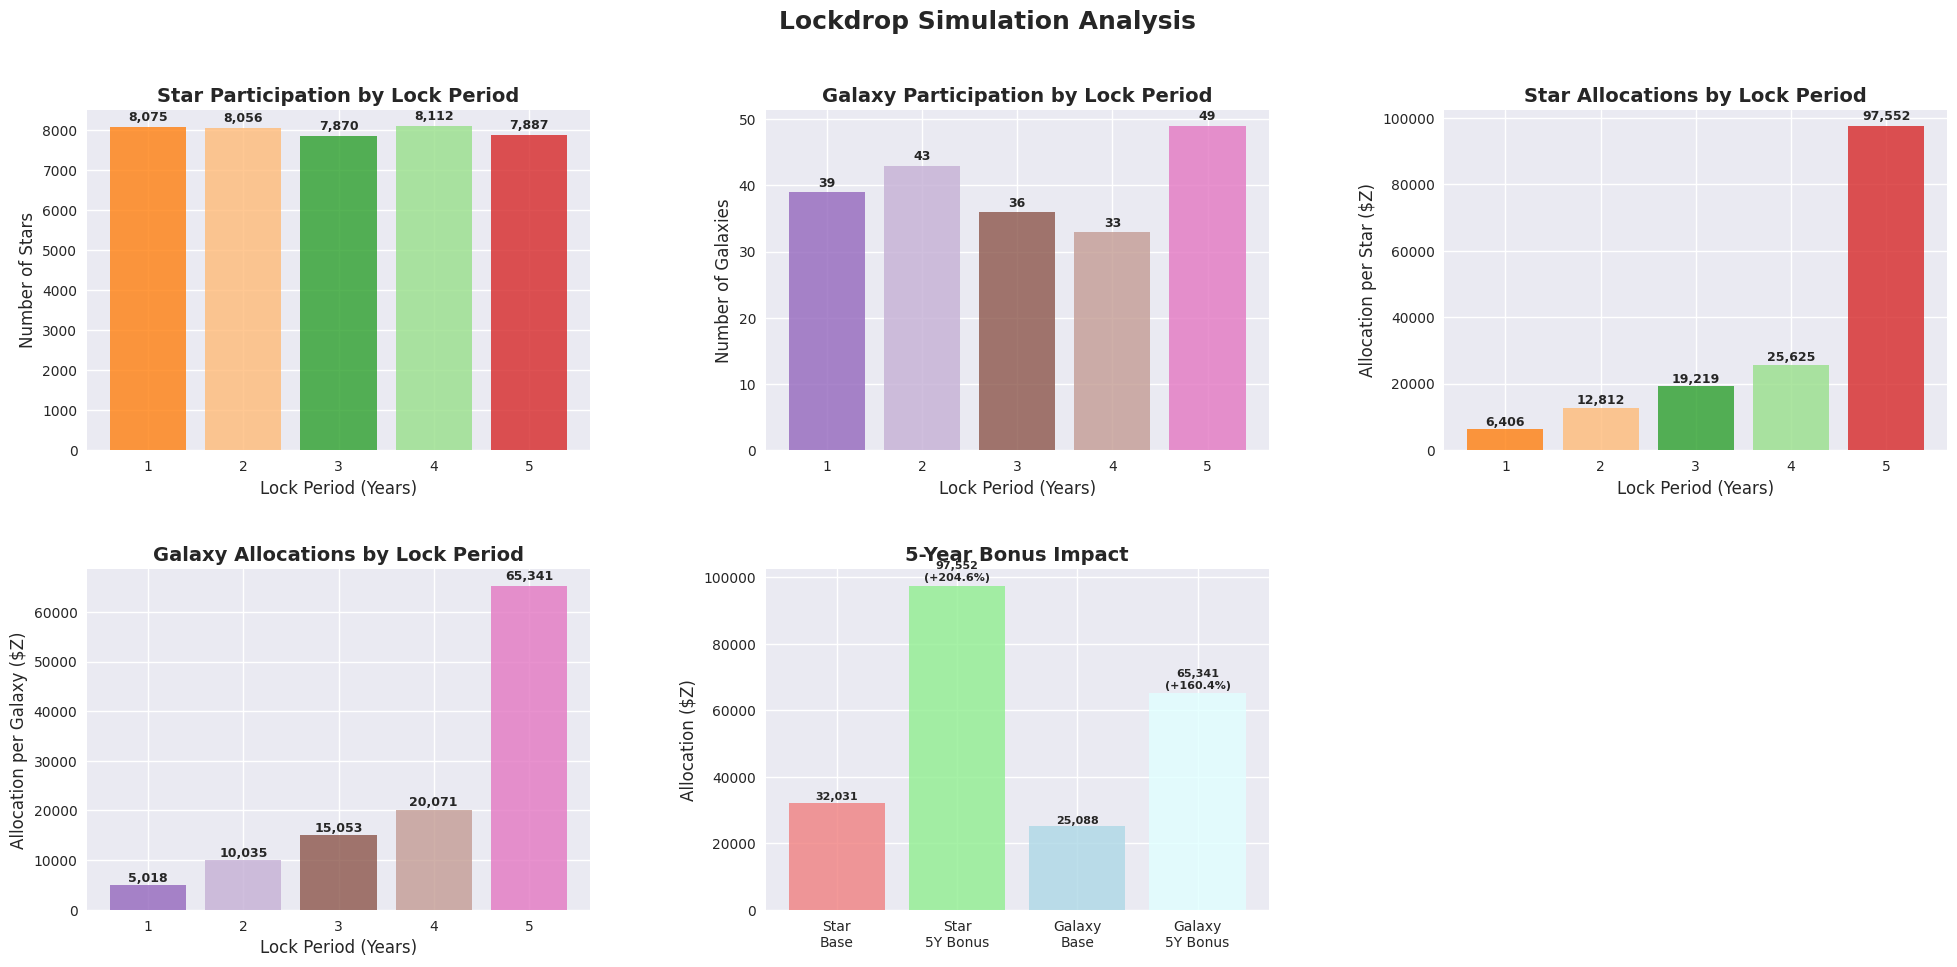

In [13]:
# Create comprehensive visualization for dynamic lockdrop simulation

fig = plt.figure(figsize=(20, 10))
gs = fig.add_gridspec(2, 3, hspace=0.35, wspace=0.35)  # 2x3 grid

fig.suptitle('Lockdrop Simulation Analysis', fontsize=18, fontweight='bold', y=0.98)

# 1. Star Participation Distribution by Lock Period
ax1 = fig.add_subplot(gs[0, 0])
star_years = [1, 2, 3, 4, 5]
star_counts = [stars_1_years, stars_2_years, stars_3_years, stars_4_years, stars_5_years]

bars1 = ax1.bar(range(len(star_years)), star_counts,
               color=['#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a', '#d62728'],
               alpha=0.8)
ax1.set_xlabel('Lock Period (Years)')
ax1.set_ylabel('Number of Stars')
ax1.set_title('Star Participation by Lock Period', fontweight='bold')
ax1.set_xticks(range(len(star_years)))
ax1.set_xticklabels(star_years)

# Add value labels
for i, count in enumerate(star_counts):
    height = bars1[i].get_height()
    ax1.text(bars1[i].get_x() + bars1[i].get_width()/2., height + height*0.01,
             f'{count:,}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# 2. Galaxy Participation Distribution by Lock Period
ax2 = fig.add_subplot(gs[0, 1])
galaxy_years = [1, 2, 3, 4, 5]
galaxy_counts = [galaxies_1_years, galaxies_2_years, galaxies_3_years, galaxies_4_years, galaxies_5_years]

bars2 = ax2.bar(range(len(galaxy_years)), galaxy_counts,
               color=['#9467bd', '#c5b0d5', '#8c564b', '#c49c94', '#e377c2'],
               alpha=0.8)
ax2.set_xlabel('Lock Period (Years)')
ax2.set_ylabel('Number of Galaxies')
ax2.set_title('Galaxy Participation by Lock Period', fontweight='bold')
ax2.set_xticks(range(len(galaxy_years)))
ax2.set_xticklabels(galaxy_years)

# Add value labels
for i, count in enumerate(galaxy_counts):
    height = bars2[i].get_height()
    ax2.text(bars2[i].get_x() + bars2[i].get_width()/2., height + height*0.01,
             f'{count:,}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# 3. Star Allocations by Lock Period
ax3 = fig.add_subplot(gs[0, 2])
star_allocations = [
    float(allocation_per_star_1_years),
    float(allocation_per_star_2_years),
    float(allocation_per_star_3_years),
    float(allocation_per_star_4_years),
    float(allocation_per_star_5_years)
]

bars3 = ax3.bar(range(len(star_years)), star_allocations,
               color=['#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a', '#d62728'],
               alpha=0.8)
ax3.set_xlabel('Lock Period (Years)')
ax3.set_ylabel('Allocation per Star ($Z)')
ax3.set_title('Star Allocations by Lock Period', fontweight='bold')
ax3.set_xticks(range(len(star_years)))
ax3.set_xticklabels(star_years)

# Add value labels
for i, allocation in enumerate(star_allocations):
    height = bars3[i].get_height()
    ax3.text(bars3[i].get_x() + bars3[i].get_width()/2., height + height*0.01,
             f'{allocation:,.0f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# 4. Galaxy Allocations by Lock Period
ax4 = fig.add_subplot(gs[1, 0])
galaxy_allocations = [
    float(allocation_per_galaxy_1_years),
    float(allocation_per_galaxy_2_years),
    float(allocation_per_galaxy_3_years),
    float(allocation_per_galaxy_4_years),
    float(allocation_per_galaxy_5_years)
]

bars4 = ax4.bar(range(len(galaxy_years)), galaxy_allocations,
               color=['#9467bd', '#c5b0d5', '#8c564b', '#c49c94', '#e377c2'],
               alpha=0.8)
ax4.set_xlabel('Lock Period (Years)')
ax4.set_ylabel('Allocation per Galaxy ($Z)')
ax4.set_title('Galaxy Allocations by Lock Period', fontweight='bold')
ax4.set_xticks(range(len(galaxy_years)))
ax4.set_xticklabels(galaxy_years)

# Add value labels
for i, allocation in enumerate(galaxy_allocations):
    height = bars4[i].get_height()
    ax4.text(bars4[i].get_x() + bars4[i].get_width()/2., height + height*0.01,
             f'{allocation:,.0f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# 5. 5-Year Bonus Impact (Stars and Galaxies)
ax5 = fig.add_subplot(gs[1, 1])
categories = ['Star\nBase', 'Star\n5Y Bonus', 'Galaxy\nBase', 'Galaxy\n5Y Bonus']
star_5y_base = float(adjusted_max_allocation_per_star)
star_5y_final = float(allocation_per_star_5_years)
galaxy_5y_base = float(adjusted_max_allocation_per_galaxy)
galaxy_5y_final = float(allocation_per_galaxy_5_years)

star_efficiency_gain = (star_5y_final / star_5y_base - 1) * 100
galaxy_efficiency_gain = (galaxy_5y_final / galaxy_5y_base - 1) * 100

bonus_values = [star_5y_base, star_5y_final, galaxy_5y_base, galaxy_5y_final]
colors_bonus = ['lightcoral', 'lightgreen', 'lightblue', 'lightcyan']

bars5 = ax5.bar(range(len(categories)), bonus_values, color=colors_bonus, alpha=0.8)
ax5.set_ylabel('Allocation ($Z)')
ax5.set_title('5-Year Bonus Impact', fontweight='bold')
ax5.set_xticks(range(len(categories)))
ax5.set_xticklabels(categories)

# Add value labels
labels = [
    f'{star_5y_base:,.0f}',
    f'{star_5y_final:,.0f}\n(+{star_efficiency_gain:.1f}%)',
    f'{galaxy_5y_base:,.0f}',
    f'{galaxy_5y_final:,.0f}\n(+{galaxy_efficiency_gain:.1f}%)'
]

for i, (bar, label) in enumerate(zip(bars5, labels)):
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             label, ha='center', va='bottom', fontweight='bold', fontsize=8)

# Hide the 6th subplot area (bottom right)
ax6 = fig.add_subplot(gs[1, 2])
ax6.axis('off')

# Manual layout adjustment with more space at top for title
plt.subplots_adjust(bottom=0.08, top=0.88, left=0.05, right=0.98)
plt.show()